<p style="font-size:78px">Final Project IRWA (2024-2025)</p>

<p style="font-size:48px">Part 1: Text Processing and Exploratory Data Analysis</p>

In [6]:
# Standard library imports
import os
import sys
from collections import Counter
from itertools import chain
from statistics import mean

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import spacy



# Local application imports
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
project_root = os.path.join(current_dir, '..')
if project_root not in sys.path:
    sys.path.append(project_root)
import irwa.loading as ild 
import irwa.preprocessing as ipp

# The following lines allow for autoreload of modules. They allow changes in modules without the need to reload the kernel.
%load_ext autoreload
%autoreload 2

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('vader_lexicon')
spacy.cli.download("en_core_web_sm")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /home/iv97n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/iv97n/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/iv97n/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/iv97n/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1) Pre-processing the documents

In [7]:
# Loading the tweets
file_path = '../data/farmers-protest-tweets.json'
tweets = ild.load_tweets_from_json(file_path)
print(f"Loaded {len(tweets)} tweets")

Loaded 117407 tweets


In [8]:
# Preprocessing the tweets
tweet_document_ids_map_df = "../data/tweet_document_ids_map.csv"
token_tweets = ipp.create_tokenized_dictionary(tweets, tweet_document_ids_map_df)
print(f"Loaded {len(token_tweets)} documents with their corresponding tokenized tweet content")

Loaded 48429 documents with their corresponding tokenized tweet content


In [10]:
# Look at first 5 documents to make sure preprocessing worked
for doc_id, tokens in list(token_tweets.items())[:5]:
    print(f"Document ID: {doc_id}, Tokens: {tokens}")

Document ID: doc_0, Tokens: ['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', '#modidontsellfarm', '#farmersprotest', '#freenodeepkaur', 'https://t.co/es3kn0iqaf']
Document ID: doc_1, Tokens: ['#farmersprotest', '#modiignoringfarmersdeath', '#modidontsellfarm', 'kisanektamorcha', 'farmer', 'constantli', 'distroy', 'crop', 'throughout', 'india', 'realli', 'heart', 'breakingw', 'care', 'crop', 'like', 'children', 'govt', 'agricultur', 'minist', 'laugh', 'us🚜🌾w', 'win💪', 'https://t.co/klspngg9xe']
Document ID: doc_2, Tokens: ['reallyswara', 'rohinisgh', 'watch', 'full', 'video', '#farmersprotest', '#nofarmersnofood', 'https://t.co/wbpndjdb0n', 'https://t.co/fustokocxk']
Document ID: doc_3, Tokens: ['mandeeppunia1', 'watch', 'full', 'video', '#farmersprotest', '#nofarmersnofood', 'https://t.co/wbpndjdb0n', 'https://t.co/71imqec6ak']
Document ID: doc_4, Tokens: ['mandeeppunia1', 'watc

# 2) Exploratory Data Analysis

## Word Count

In [12]:
def word_count(tweets, top_words, count_type='all'):
    """
    Counts the most common words in a collection of tokenized tweets.

    Parameters:
    tweets (dict): A dictionary where keys are tweet identifiers and values are lists of words in the tweets.
    top_words (int): The number of top most common words to retrieve.
    count_type (str): An optional parameter to filter the type of words to count. It can take the values 'all' (default), 'hashtags', or 'no_hashtags'.

    Returns:
    word_counts (Counter): A Counter object containing the word counts.
    most_common_words (list): A list of tuples representing the most common words and their counts.
    """
    all_words = list(chain.from_iterable(tweets.values()))

    if count_type == "hashtags":
        words_to_count = [word for word in all_words if word.startswith('#')]  
    elif count_type == "no_hashtags":
        words_to_count = [word for word in all_words if not word.startswith('#')] 
    else:
        words_to_count = all_words  

    word_counts= Counter(words_to_count)
    most_common_words = word_counts.most_common(top_words)
    return word_counts, most_common_words


def plot_word_counts(most_common_words, ax):
    """
    Plots the most common words as a horizontal bar chart.

    Parameters:
    most_common_words (list): A list of tuples representing the most common words and their counts.
    ax (Axes): A Matplotlib Axes object on which the bar chart will be plotted.
    """
    most_common_words.sort(key=lambda x: x[1], reverse=True)
    words, counts = zip(*most_common_words)

    norm_counts = np.array(counts) / max(counts)
    bars = ax.barh(words, counts, color=plt.cm.Blues(norm_counts))

    for bar, count in zip(bars, counts):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count), 
                ha='left', va='center', fontsize=10)

    ax.set_title('Most Common Words in Tweets')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    ax.grid(axis='x', linestyle='--', alpha=0.7)
 


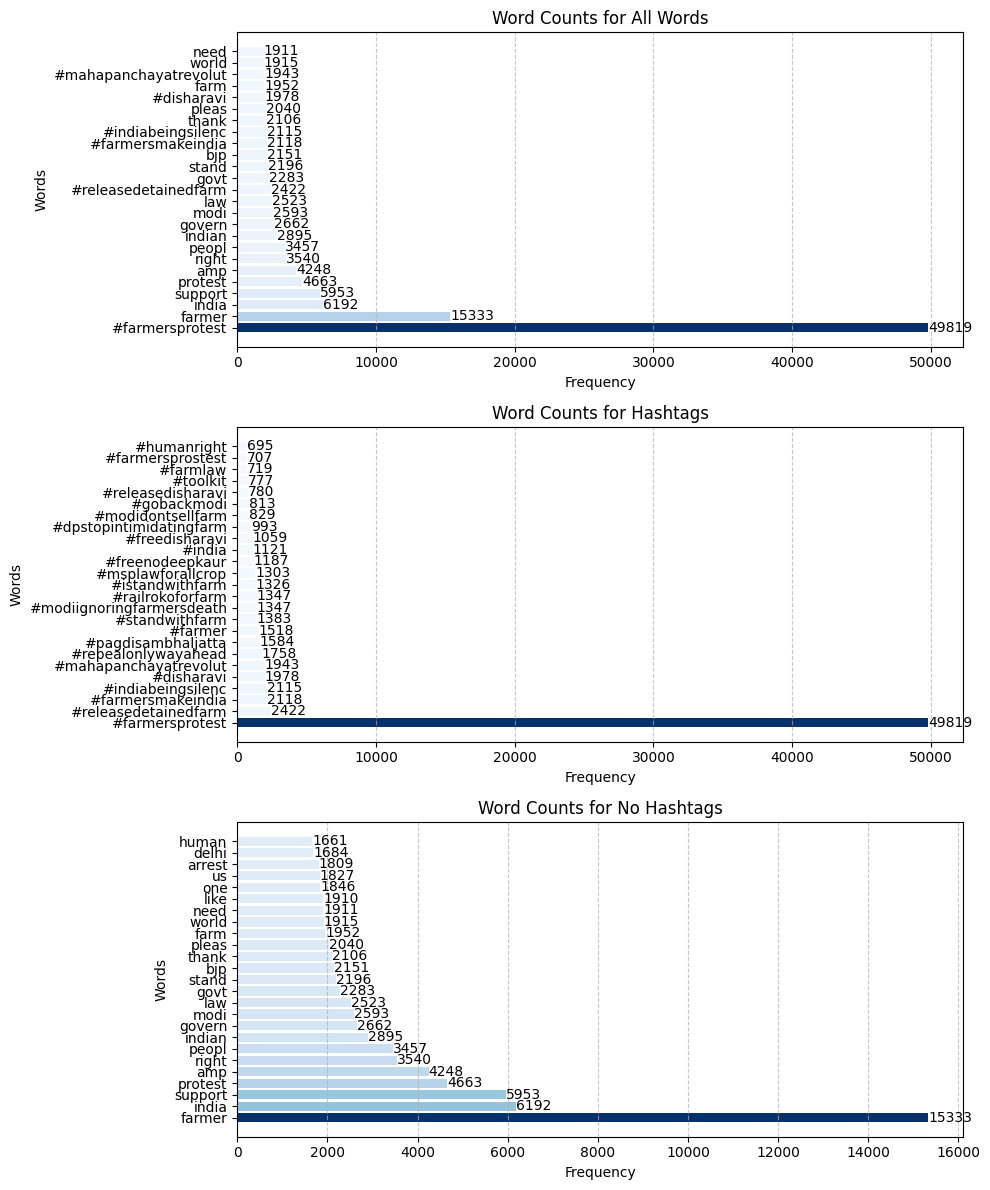

In [13]:
word_counts_all, most_common_words_all = word_count(token_tweets, top_words=25, count_type='all') # Including all words
word_counts_ht, most_common_words_ht = word_count(token_tweets, top_words=25, count_type='hashtags') # Only hashtags
word_counts_noht, most_common_words_noht = word_count(token_tweets, top_words=25, count_type='no_hashtags') # No hashtags

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

plot_word_counts(most_common_words_all, ax=axs[0])
axs[0].set_title('Word Counts for All Words')

plot_word_counts(most_common_words_ht, ax=axs[1])
axs[1].set_title('Word Counts for Hashtags')

plot_word_counts(most_common_words_noht, ax=axs[2])
axs[2].set_title('Word Counts for No Hashtags')

plt.tight_layout()
plt.show()

## Average Tweet Length

In [14]:
def average_tweet_length(token_tweets):
    """
    Calculates the average length of tweets in terms of word count.

    Parameters:
    token_tweets (dict): A dictionary where keys are tweet identifiers and values are lists of tokenized words from each tweet.

    Returns:
    float: The average length of the tweets.
    """
    tweet_lengths = []

    for tokenized_content in token_tweets.values():
        tweet_count = 1  # Since tokenized_content corresponds to one document (one tweet)
        word_count = len(tokenized_content)  # Number of words in the tokenized content

        avg_length = word_count / tweet_count
        tweet_lengths.append(avg_length)

    # Compute overall average tweet length
    avg_tweet_length = mean(tweet_lengths)
    return avg_tweet_length

In [15]:
avg_tweet_length = average_tweet_length(token_tweets)
print(f"📊 Average Tweet Length")
print(f"-----------------------------------")
print(f"The average tweet length is {avg_tweet_length:.2f} words")

📊 Average Tweet Length
-----------------------------------
The average tweet length is 14.99 words


## Most retweeted Tweets

In [16]:
def top_retweeted_tweets(tweets, csv_file_path, n=10):
    """
    Finds the top n most retweeted tweets.

    Parameters:
    tweets (dict): A dictionary where keys are tweet identifiers and values are tweet objects containing tweet details.
    n (int): The number of top retweeted tweets to retrieve. Default is 10.

    Returns:
    list: A list of tuples containing tweet IDs, retweet counts, and tweet content of the top retweeted tweets.
    """

    # Load the mapping of doc_id to tweet_id from the CSV file
    tweet_mapping = pd.read_csv(csv_file_path)

    # Create tokenized dictionary with doc_id as key
    tokenized_lst = []
    for _, row in tweet_mapping.iterrows():
        doc_id = row['docId']
        tweet_id = row['id']
        if tweet_id in tweets:
            tweet = tweets[tweet_id]
            tokenized_lst.append((tweet_id,tweet._retweet_count, tweet._content))

    ranked_tweets = sorted(tokenized_lst, key=lambda x: x[1], reverse=True)[:n]
    '''
    tweets = [tweet for _, tweet in tokenized_dict.items()]
    ranked_tweets = sorted(tweets, key=lambda tweet: tweet._retweet_count, reverse=True)
    top_retweets = [(tweet._tweet_id, tweet._retweet_count, tweet._content) for tweet in ranked_tweets[:n]]'''
    return ranked_tweets


def plot_top_retweet_tweets(tweets, csv_file, n=10):
    """
    Plots the top n most retweeted tweets as a horizontal bar chart and prints their content.

    Parameters:
    tweets (dict): A dictionary where keys are tweet identifiers and values are tweet objects containing tweet details.
    n (int): The number of top retweeted tweets to plot. Default is 10.
    """
    
    if not tweets:
        print("No tweets to display.")
        return
    
    top_tweets = top_retweeted_tweets(tweets, csv_file, n)
    
    # Unzip the tweet IDs and retweet counts
    tweet_ids, retweet_counts, retweet_content = zip(*top_tweets)
    tweet_ids = list(map(str, tweet_ids))  # Convert tweet IDs to string if necessary


    # Create a horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(tweet_ids, retweet_counts, color='skyblue')

    plt.title('Top 10 Most Retweeted Tweets')
    plt.xlabel('Number of Retweets')
    plt.ylabel('Tweet IDs')
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability
    plt.tight_layout()

    plt.show()

    aux = 1
    for tweet_id, retweet_count, retweet_content in top_tweets:
        print("\n\n--------------------------------------------------------------------------------------------------------")
        print("Most Retweeted Ranking:" , aux , "   Tweet ID: ",{tweet_id},"Retweets:",{retweet_count},"\nContent: ",{retweet_content})
        aux+=1
        print("--------------------------------------------------------------------------------------------------------")

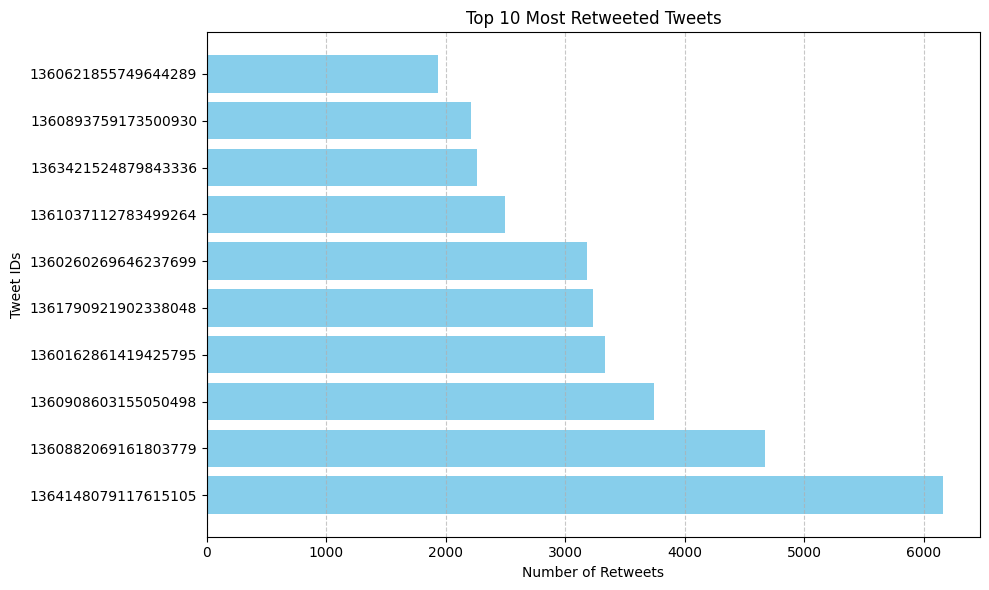



--------------------------------------------------------------------------------------------------------
Most Retweeted Ranking: 1    Tweet ID:  {1364148079117615105} Retweets: {6164} 
Content:  {"There's a #FarmersProtest happening in Germany.\n\nBut the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8"}
--------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------
Most Retweeted Ranking: 2    Tweet ID:  {1360882069161803779} Retweets: {4673} 
Content:  {'disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. \n\ndisha’s arrest is alarming and 

In [17]:
plot_top_retweet_tweets(tweets, tweet_document_ids_map_df, n=10)

## Word Cloud

In [18]:
def create_word_cloud(word_counts, top_words, title):
    
    """
    Creates and displays a word cloud from the given word counts.

    Parameters:
    word_counts (Counter): A Counter object containing the word counts.
    top_words (int): The number of top most common words to display in the word cloud.
    title (str): The title of the word cloud plot.

    Returns:
    None
    """
    
    # Get the most common words
    most_common_words = word_counts.most_common(top_words)

    # Create a WordCloud object with custom settings
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',  # Dark background for contrast
        colormap='Set2',           # Color palette for the words
        max_words=top_words,       # Maximum number of words to display
    ).generate_from_frequencies(dict(most_common_words))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.title(title, fontsize=18, color='black', pad=20)
    plt.show()



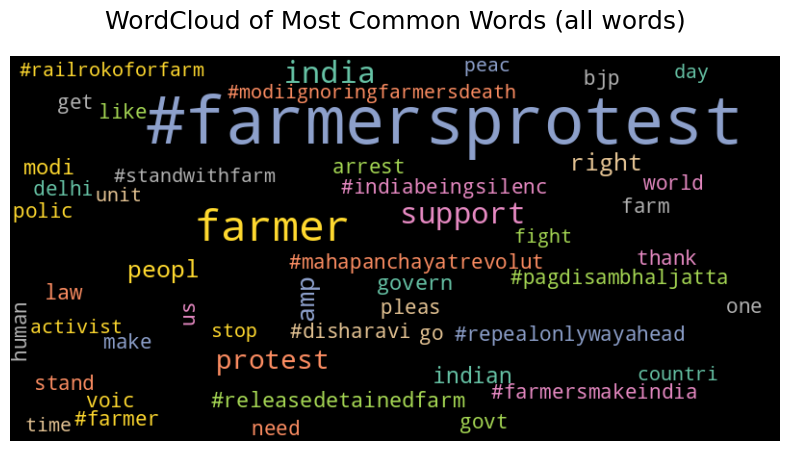

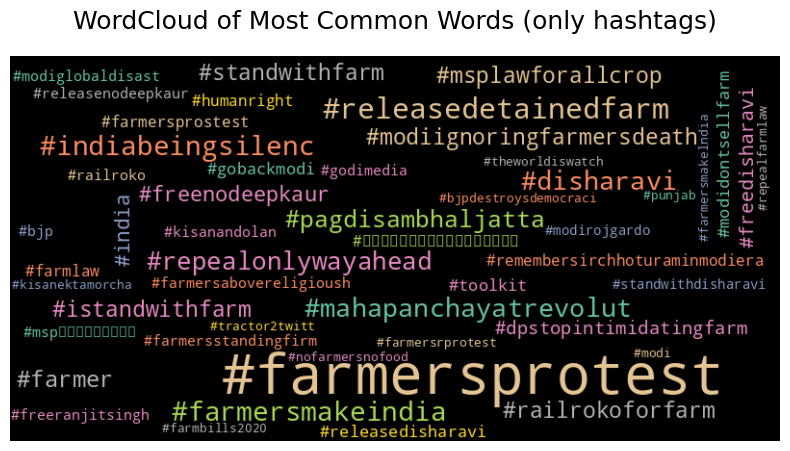

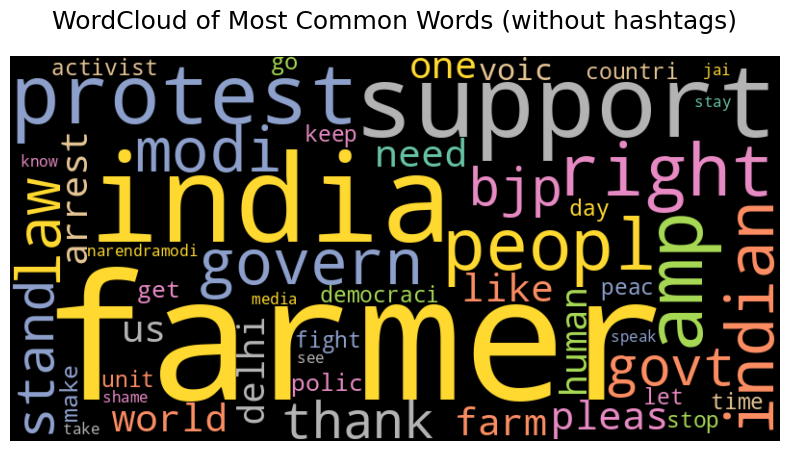

In [19]:
# Use the word counts from the earlier analysis
create_word_cloud(word_counts_all, 50, "WordCloud of Most Common Words (all words)") #all words
create_word_cloud(word_counts_ht, 50, "WordCloud of Most Common Words (only hashtags)") # only hashtags
create_word_cloud(word_counts_noht, 50, "WordCloud of Most Common Words (without hashtags)") # words without hashtags

## Vocabulary Size

In [20]:
def calc_vocabulary_size(word_counts):
    """
    Calculates the vocabulary size from the given word counts.

    Parameters:
    word_counts (Counter): A Counter object containing the word counts.

    Returns:
    int: The number of unique words (vocabulary size).
    """
    return len(word_counts)

In [21]:
vocab_size = calc_vocabulary_size(word_counts_all)
print(f"📊 Vocabulary Size")
print(f"-----------------------------------")
print(f"The length of the vocabulary is {vocab_size} words, including hashtags.")

📊 Vocabulary Size
-----------------------------------
The length of the vocabulary is 79166 words, including hashtags.


## Entity Recognition

In [22]:
nlp = spacy.load("en_core_web_sm")

In [23]:
def create_nontokenized_dictionary(tweets, csv_file_path):
    """Function to map tweets to a doc_id

    Args:
        tweets (Dict[id, Tweet]): dicitonary containing the mapping between tweet ids and tweet objects
        csv_file_path (str): path to the mapping csv

    Returns:
        Dict[str, List[str]]: dicitonary mapping from document id to the tweet content
    """
    # Load the mapping of doc_id to tweet_id from the CSV file
    tweet_mapping = pd.read_csv(csv_file_path)

    # Create tokenized dictionary with doc_id as key
    tokenized_dict = {}
    for _, row in tweet_mapping.iterrows():
        doc_id = row['docId']
        tweet_id = row['id']
        if tweet_id in tweets:
            tokenized_dict[doc_id] = tweets[tweet_id]._content

    return tokenized_dict

In [24]:
#SPACY APPROACH - FASTER THAN NLTK
def entity_recognition_spacy(sentences, print_results=False):
    entities = []

    # Process the non-tokenized tweet sentences
    for id, sentence in sentences.items():
        # Process the text with SpaCy
        doc = nlp(sentence)

        # Extract entities
        for ent in doc.ents:
            entities.append((id, ent.text, ent.label_))

    if print_results:
        for id, entity, label in entities:
            print(f"ID: '{id}' | Entity: '{entity}' | Label: '{label}'")
    
    return entities

def plot_entity_recognition(entities):
    label_counts = Counter(label for _, _, label in entities)
    sorted_counts = sorted(label_counts.items(), key=lambda item: item[1], reverse=True)
    labels, counts = zip(*sorted_counts)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a bar plot
    bars = ax.bar(labels, counts, color='skyblue')

    # Add labels and title
    ax.set_xlabel('Entity Label')
    ax.set_ylabel('Count')
    ax.set_title('Summary of Entity Counts')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add counts above the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Display the plot
    plt.tight_layout()
    plt.show()    

In [25]:
# Create non-tokenized dictionary for better entity recognition.
tweet_document_ids_map_df = "../data/tweet_document_ids_map.csv"
nontoken_tweets = create_nontokenized_dictionary(tweets, tweet_document_ids_map_df)

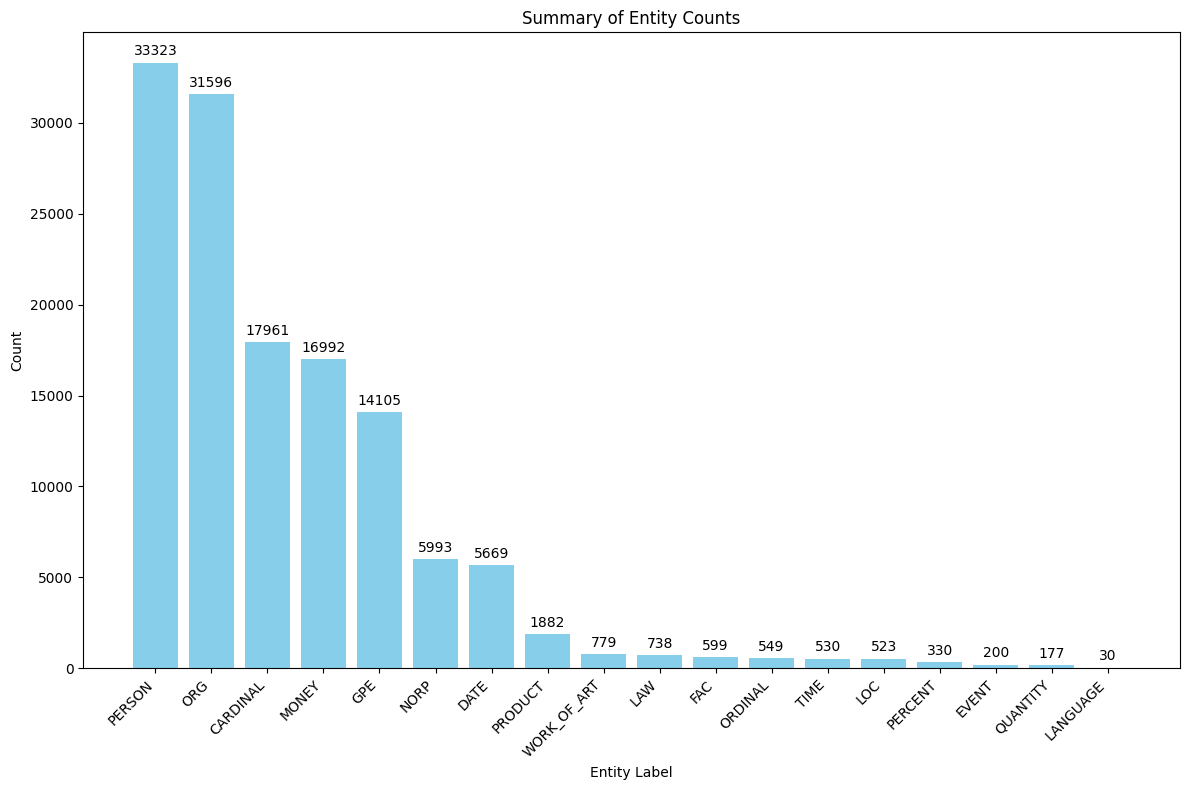

In [26]:
entities = entity_recognition_spacy(nontoken_tweets, print_results=False)
plot_entity_recognition(entities)

## Sentiment Analysis

We've decided to also do a sentiment analysis study that can be really usefull to understand the data.

In [28]:
def calculate_sentiment_scores(token_tweets):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = {}

    # Iterate over the dictionary with tokenized tweets
    for tweet_id, token_list in token_tweets.items():
        # Join the token list back into a single string
        tweet_text = ' '.join(token_list)
        sentiment = analyzer.polarity_scores(tweet_text)  # Get sentiment scores
        sentiment_scores[tweet_id] = sentiment['compound']  # Use compound score

    return sentiment_scores

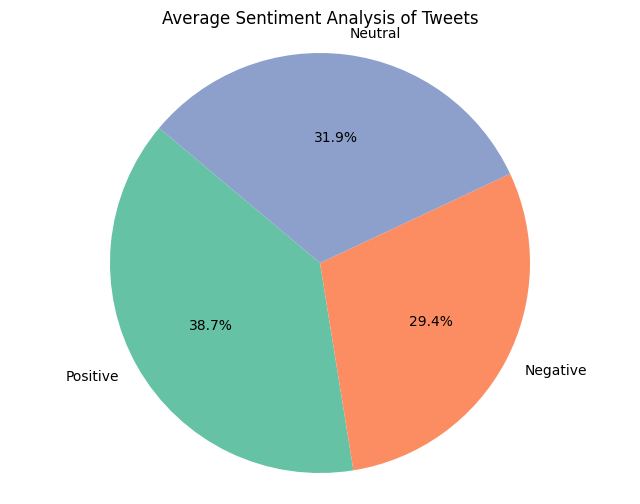

In [29]:

def plot_sentiment_pie(sentiment_scores):
    
    # Categorize each tweet's sentiment
    sentiment_categories = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
    
    for score in sentiment_scores.values():
        if score > 0:
            sentiment_categories['Positive'] += 1
        elif score < 0:
            sentiment_categories['Negative'] += 1
        else:
            sentiment_categories['Neutral'] += 1

    # Prepare data for pie chart
    labels = list(sentiment_categories.keys())
    sizes = list(sentiment_categories.values())
    
    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
    plt.title('Average Sentiment Analysis of Tweets')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

sentiment_scores = calculate_sentiment_scores(token_tweets)
plot_sentiment_pie(sentiment_scores)